In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fastica = loadmat("drive/MyDrive/icasig.mat")['icasig'] # sampled at 250Hz
mtx = loadmat("drive/MyDrive/mtx.mat")['mtx'] # sampled at 250Hz
eyetrack = loadmat("drive/MyDrive/EyeTrack.mat") # sampled at 120Hz
event = loadmat("drive/MyDrive/Event.mat")

In [80]:
# waiting = eyetrack['EyeTrackTime'][0].copy()

# for t in event['EventTime'][0]:
#   waiting[np.logical_and(waiting > t, waiting < t + 2.5)] = -1

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


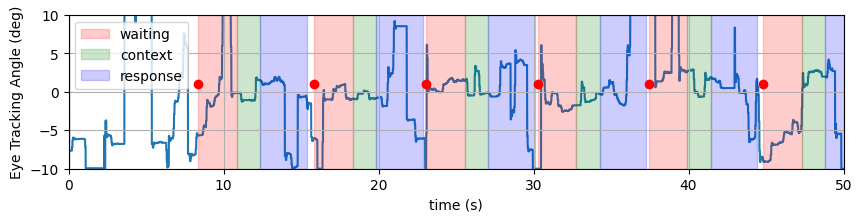

In [3]:
look_angle = eyetrack['EyeTrackData'].T[2, :]

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(np.linspace(0, look_angle.shape[0] / 120, look_angle.shape[0]), look_angle, zorder=1)
ax.scatter(event['EventTime'], np.linspace(1, 1, event['EventTime'].shape[1]), c='red', zorder=3)
ax.set(xlabel='time (s)', ylabel='Eye Tracking Angle (deg)')
ax.grid()


for t in event['EventTime'][0]:
  ax.axvspan(t, t + 2.5, alpha=0.2, color='red')
  ax.axvspan(t + 2.5, t + 4, alpha=0.2, color='green')
  ax.axvspan(t + 4, t + 7, alpha=0.2, color='blue')

# labels for legend
ax.axvspan(0, 0, alpha=0.2, color='red', label='waiting')
ax.axvspan(0, 0, alpha=0.2, color='green', label='context')
ax.axvspan(0, 0, alpha=0.2, color='blue', label='response')
plt.legend()

plt.xlim(0, 50)
plt.ylim(-10, 10)
plt.show()

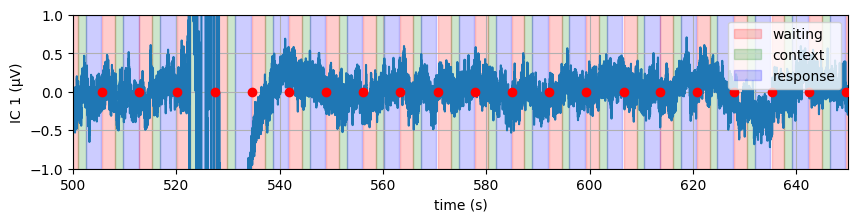

In [92]:
look_angle = eyetrack['EyeTrackData'].T[2, :]

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(np.linspace(0, fastica.shape[1] / 250, fastica.shape[1]), fastica[0], zorder=2)
ax.scatter(event['EventTime'], np.linspace(0, 0, event['EventTime'].shape[1]), c='red', zorder=3)
ax.set(xlabel='time (s)', ylabel='IC 1 (μV)')
ax.grid()


for t in event['EventTime'][0]:
  ax.axvspan(t, t + 2.5, alpha=0.2, color='red')
  ax.axvspan(t + 2.5, t + 4, alpha=0.2, color='green')
  ax.axvspan(t + 4, t + 7, alpha=0.2, color='blue')

# labels for legend
ax.axvspan(0, 0, alpha=0.2, color='red', label='waiting')
ax.axvspan(0, 0, alpha=0.2, color='green', label='context')
ax.axvspan(0, 0, alpha=0.2, color='blue', label='response')
plt.legend(loc='upper right')

plt.xlim(500, 650)
plt.ylim(-1, 1)
plt.show()

In [80]:
from sklearn.model_selection import train_test_split

binsize = 250 # 1second * 250Hz
n = len(event['EventData'][0])

X = np.zeros((n * 3, 128 * binsize))
y = np.zeros((n * 3,))

pruned = fastica.copy()
for i in range(n):
  # context
  # begin = int(event['EventTime'][0][i] + 4 * 250)
  waiting = int(event['EventTime'][0][i] + 0 * 250)
  context = int(event['EventTime'][0][i] + 2.5 * 250)
  response = int(event['EventTime'][0][i] + 4 * 250)

  X[i*3] = np.hstack(pruned[:,waiting:waiting+binsize])
  X[i*3+1] = np.hstack(pruned[:,context:context+binsize])
  X[i*3+2] = np.hstack(pruned[:,response:response+binsize])
  y[i*3] = 0
  y[i*3+1] = 1
  y[i*3+2] = 2


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

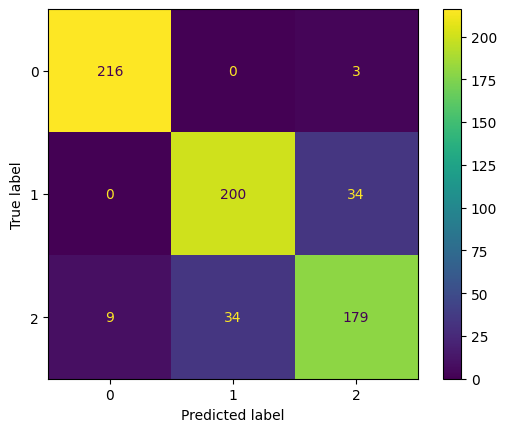

In [90]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

reg = RandomForestClassifier(max_depth=7)
reg.fit(X_train, y_train)
# y_pred = reg.predict(X_test)
y_pred = reg.predict(X_train)

cm = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
# print(reg.score(X_test, y_test))